**Load Data**

In [84]:
# Useful imports
import os
import re
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from sklearn.model_selection import train_test_split

# Useful globals
batch_size = 128  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

In [85]:
# Where to find the data
base_dir = "./data"

def load_data(language):
    """
        Loads the books to be processed
        and returns them as a list of strings.

        Input:
            string: Language whose books to load
            number: Number of books to process

        Ouput:
            list: List of strings of the loaded books
    """
    # Output
    books = []

    # Working path
    wrk_path = "{}/{}".format(base_dir, language)

    # Books' filenames
    book_files = os.listdir(wrk_path)

    # Read each book and append
    for book_file in book_files:
        input_file = "{}/{}".format(wrk_path, book_file)
        with open(input_file) as f:
            book = f.read()
            books.append(book)

    # Useful logs about books
    print("Loaded {} books for {}.".format(len(books), language))
    for i in range(len(books)):
        print("There are {} words in {}.".format(len(books[i].split()), book_files[i]))

    return books

In [86]:
books = load_data("english")

Loaded 10 books for english.
There are 74964 words in book2.txt.
There are 26436 words in book3.txt.
There are 121561 words in book1.txt.
There are 211862 words in book4.txt.
There are 135594 words in book5.txt.
There are 37901 words in book7.txt.
There are 25572 words in book6.txt.
There are 12161 words in book8.txt.
There are 100649 words in book9.txt.
There are 69693 words in book10.txt.


**Data Preparation**

In [87]:
def clean_book(book):
    """
        Remove unwanted special characters
        and extra spaces from the text.
        
        Input:
            list: List of books
        Output:
            list: Cleaned list of books
    """
    book = re.sub(r'\n', ' ', book) 
    book = re.sub(r'[{}@_*>()\\#%+=\[\]]','', book)
    book = re.sub('a0','', book)
    book = re.sub('\'92t','\'t', book)
    book = re.sub('\'92s','\'s', book)
    book = re.sub('\'92m','\'m', book)
    book = re.sub('\'92ll','\'ll', book)
    book = re.sub('\'91','', book)
    book = re.sub('\'92','', book)
    book = re.sub('\'93','', book)
    book = re.sub('\'94','', book)
    book = re.sub('\.','. ', book)
    book = re.sub('\!','! ', book)
    book = re.sub('\?','? ', book)
    book = re.sub(' +',' ', book)
    return book

In [88]:
# Clean books
clean_books = []
for book in books:
    clean_books.append(clean_book(book))

In [89]:
# Create a dictionary to convert the vocabulary (characters) to integers
vocab_to_int = {}
count = 0
for book in clean_books:
    for character in book:
        if character not in vocab_to_int:
            vocab_to_int[character] = count
            count += 1

In [90]:
# Check the size of vocabulary and all of the values
vocab_size = len(vocab_to_int)
print("The vocabulary contains {} characters.".format(vocab_size))
print(sorted(vocab_to_int))

The vocabulary contains 88 characters.
[' ', '!', '$', '&', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£', 'à', 'â', 'æ', 'è', 'é', 'ê', 'ô', 'œ', '—', '‘', '’', '“', '”']


In [91]:
# Int to vocab
int_to_vocab = {}
for character, value in vocab_to_int.items():
    int_to_vocab[value] = character

In [92]:
# Create sentences from the books
sentences = []
for book in clean_books:
    for sentence in book.split(". "):
        sentences.append(sentence + ".")
print("There are {} sentences".format(len(sentences)))

There are 35662 sentences


In [93]:
# # Convert sentences to integers
# int_sentences = []
# for sentence in sentences:
#     int_sentence = []
#     for character in sentence:
#         int_sentence.append(vocab_to_int[character])
#     int_sentences.append(int_sentence)

In [94]:
# Limit data for training
max_length = 92
min_length = 10

good_sentences = []

for sentence in sentences:
    if len(sentence) <= max_length and len(sentence) >= min_length:
        good_sentences.append(sentence)
print("We will use {} sentences to train and test our model.".format(len(good_sentences)))

We will use 15298 sentences to train and test our model.


In [95]:
# Noise maker (input sequences)
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]

def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0,1,1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0,1,1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i+1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_int = np.random.randint(0, len(int_to_vocab)-1)
                noisy_sentence.append(int_to_vocab[random_int])
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass     
        i += 1
    return noisy_sentence

In [96]:
# Check to ensure noise_maker is making mistakes correctly.
threshold = 0.9
for sentence in good_sentences[:5]:
    print(sentence)
    print("".join(noise_maker(sentence, threshold)))
    print()

Inspirited by this wind of promise, my daydreams become more fervent and vivid.
Inspirited y this windzoCf promWies”, ym ayrdeams become more fervent and ivvid.

This expedition has been the favourite dream of my early years.
This expeditijon ha bee nthe !favourite dream of my early years2.

My education was neglected, yet I was passionately fond of reading.
Myeucation as nglected, yet I  was passonately Df—ond ofreading.

You are well acquainted with my failure and how heavily I bore the disappointment.
You are wel cauqian—ted with my failuey ?and hoqw heaviy I bore the disapointment.

Six years have passed since I resolved on my present undertaking.
Six ears hve passd since I resoved on m`y persent undert&aking.



In [97]:
# Create input and target text
input_texts = []
target_texts = []

input_characters = set()
target_characters = set()

# Shuffle the list of good_senteces
np.random.shuffle(good_sentences)

# Split list of good sentences into
# training and testing sets
# training, testing = train_test_split(good_sentences, test_size = 0.15, random_state = 2)

# Pad target sentences and build
# input and target vocabulary
for sentence in good_sentences:
    input_text = "".join(noise_maker(sentence, 0.9))
    target_text = "{}{}{}".format("\t", sentence , "\n")
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

# Set up our encoder and decoder inputs
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

# Logging
# print('Number of samples:', len(input_texts))
# print('Number of unique input tokens:', num_encoder_tokens)
# print('Number of unique output tokens:', num_decoder_tokens)
# print('Max sequence length for inputs:', max_encoder_seq_length)
# print('Max sequence length for outputs:', max_decoder_seq_length)

# Create dicts for the input and
# target vocabolaries
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# Crete vectorize data placeholders 
# for encoder and decoder
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

**Build Model**

In [98]:
# Populate tensors
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [99]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [100]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [101]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [52]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 5060 samples, validate on 1266 samples
Epoch 1/100
5060/5060 [==============================] - 74s 15ms/step - loss: 1.8130 - acc: 0.0984 - val_loss: 1.7430 - val_acc: 0.1077
Epoch 2/100
5060/5060 [==============================] - 74s 15ms/step - loss: 1.6589 - acc: 0.1253 - val_loss: 1.5573 - val_acc: 0.1481
Epoch 3/100
5060/5060 [==============================] - 74s 15ms/step - loss: 1.4828 - acc: 0.1739 - val_loss: 1.4367 - val_acc: 0.1725
Epoch 4/100
5060/5060 [==============================] - 80s 16ms/step - loss: 1.3744 - acc: 0.1933 - val_loss: 1.3589 - val_acc: 0.1841
Epoch 5/100
5060/5060 [==============================] - 83s 16ms/step - loss: 1.3092 - acc: 0.2070 - val_loss: 1.3085 - val_acc: 0.1969
Epoch 6/100
5060/5060 [==============================] - 79s 16ms/step - loss: 1.2591 - acc: 0.2192 - val_loss: 1.2504 - val_acc: 0.2125
Epoch 7/100
5060/5060 [==============================] - 78s 15ms/step - loss: 1.2194 - acc: 0.2292 - val_loss: 1.2297 - val_acc: 

5060/5060 [==============================] - 58s 11ms/step - loss: 0.6021 - acc: 0.3947 - val_loss: 0.9314 - val_acc: 0.3048
Epoch 61/100
5060/5060 [==============================] - 57s 11ms/step - loss: 0.5970 - acc: 0.3957 - val_loss: 0.9282 - val_acc: 0.3072
Epoch 62/100
5060/5060 [==============================] - 58s 11ms/step - loss: 0.5909 - acc: 0.3977 - val_loss: 0.9302 - val_acc: 0.3064
Epoch 63/100
5060/5060 [==============================] - 58s 11ms/step - loss: 0.5850 - acc: 0.3995 - val_loss: 0.9384 - val_acc: 0.3042
Epoch 64/100
5060/5060 [==============================] - 58s 11ms/step - loss: 0.5811 - acc: 0.4007 - val_loss: 0.9436 - val_acc: 0.3043
Epoch 65/100
5060/5060 [==============================] - 848s 168ms/step - loss: 0.5744 - acc: 0.4024 - val_loss: 0.9485 - val_acc: 0.3047
Epoch 66/100
5060/5060 [==============================] - 69s 14ms/step - loss: 0.5955 - acc: 0.3970 - val_loss: 0.9654 - val_acc: 0.3006
Epoch 67/100
5060/5060 [=====================

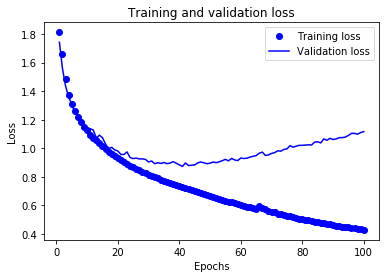

In [56]:
import matplotlib.pyplot as plt
history_dict = history.history
history_dict.keys()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 101)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

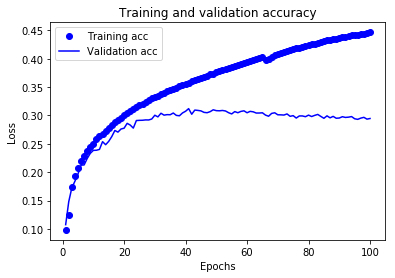

In [71]:
plt.clf()
epochs = range(1, 101)
acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
# Save model
model.save('charSeq2Seq.h5')

/Users/dailand10/Desktop/dlbaby/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/engine/network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).


**Inference**

In [63]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

ValueError: Layer lstm_4 expects 7 inputs, but it received 3 input tensors. Input received: [<tf.Tensor 'input_6:0' shape=(?, ?, 81) dtype=float32>, <tf.Tensor 'input_13:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'input_14:0' shape=(?, 256) dtype=float32>]

In [64]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: T te finny people’s king.
Decoded sentence: Bennet was really in the strent.

-
Input sentence: ” “Anothert ime, Lizzy,” sid e rmother,“ I would not dance ith him if I were you
Decoded sentence: ” “How certainly sake healtiness the sivents of a facture there, I do not.

-
Input sentence: She cAomes to usè to-day.
Decoded sentence: She was a screary of never.

-
Input sentence: ” “Tfhe county,” siad Darcy, “cani”n geneural supplb Vua few subjecs for such a stud.
Decoded sentence: ” “Haul in the curious of the way what he was sitter on that way yourself.

-
Input sentence: ” “Dear madam,cried Mrs.
Decoded sentence: ” “He isen my by.

-
Input sentence: I lov Elizabeth and lookO forward to our union with deUligh!t.
Decoded sentence: I don’t know what I had been the gleade still attention.

-
Input sentence: ollins !” “My dYear madam,W” repli2ed he, “let us befor ev’er silento n hts point.
Decoded sentence: Come on die any hand of your own shild be forney is only time a fe

-
Input sentence: “Back,l ad; I will be with ye agaibn presently.
Decoded sentence: “Yes, sir, in the bellowed him of his hand.

-
Input sentence: If I should be engaged,B I wil atD least bmake notes.
Decoded sentence: I found there is a home they are to get it.

-
Input sentence: I olokde upon them as uspeLrior beingsw ho wouldbe thnea rbiters of my future desitn.y
Decoded sentence: I travelleced my friend, and then tood placed with his deetimeresion, you know.

-
Input sentence: Snodhead,I tanscriebt he folowing: 4030,000 lbs.
Decoded sentence: Since you leffore to the contract offen.

-
Input sentence: I roused, and in“tersetdyuo, bceause I Rwas svo unlike them.
Decoded sentence: I don’t know how it is the fiesure of her sister's weak.

-
Input sentence: An invia?tionfro m he ueet o pêlay rcoquet.
Decoded sentence: And they deen helf himport of it.

-
Input sentence: “It sees Ksacrcely a houseu.
Decoded sentence: “I wish I could so.

-
Input sentence: NH office is veer to enter into